#Mina Ilkhani
#610398191
#HW3 - CNN

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


define the given parameters:

In [ ]:
BATCHSIZE = 100
NUMEPOCHS = 500
LR = 0.0001
LOSS ='binary_crossentropy'
# dataDir='/content/drive/MyDrive/term8/image/HW3/dataset'
dataDir = '/content/drive/MyDrive/HW3/dataset'

In [ ]:
imagesDir = []
imagesClass = []

imagesDirAugment = []
imagesClassAugment = []

# **augmentations**:
$flipping$, $histogram equalization$, $ratation$, $translation$, $shearing$, and **random noise** as an extra augmnetation. \
These augmentations are applied to the training data to generate additional images, thereby increasing the diversity and size of the dataset. This augmentation process helps prevent overfitting and improves the model's ability to generalize to unseen data. (using OpenCV and scikit-image libraries.)



###**Flipping**:
Flip the input image `horizontally, vertically, or both randomly`. Flipping an image horizontally means reversing it from left to right, while flipping vertically means reversing it from top to bottom.

###**Histogram Equalization**(for `3-channel` image):
Enhance the contrast of an image. For applying histogram equalization on colored images we can Split the image into color channels then apply histogram equalization to each channel and then merge them.

###**Rotation**:
The rotation augmentation randomly rotates the image by a certain angle between `5 and 355`.

###**Translation**:
Translation augmentation shifts the image along the x and y axes by a certain distance between `-60, 60` for both x and y.

###**Shearing**:
Shearing augmentation introduces shearing transformations to the image by skewing it along the x or y axis (between `0 and 1`).


---


##**extra augmnetation**
###**Random Noise**:
adds random pixel noise to the image.







In [ ]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
from skimage import util

#  1 -> horizontally
#  0 -> vertically
# -1 -> horizontally and vertically
def augmentation_flipping(image):
  return cv2.flip(image, random.choice([-1, 0, 1]))

def augmentation_histogram_eq(image):
    channels = cv2.split(image)

    equalized_channels = []
    for channel in channels:
        equalized_channels.append(cv2.equalizeHist(channel))

    equalized_image = cv2.merge(equalized_channels)

    return equalized_image

def augmentation_ratation(image ):
    angle = random.randint(5, 355)
    height, width = image.shape[:2]
    # calculate the rotation matrix
    rotation_matrix = cv2.getRotationMatrix2D((width/2, height/2), angle, 1)
    # apply rotation
    rotated_image = cv2.warpAffine(image, rotation_matrix, (width, height))
    return rotated_image

def augmentation_translation(image):
    x, y =  random.randint(-60, 60), random.randint(-60, 60)
    translation_matrix = np.float32([[1, 0, x], [0, 1, y]])
    # apply translation
    translated_image = cv2.warpAffine(image, translation_matrix, (image.shape[1], image.shape[0]))
    return translated_image

def augmentation_shearing(image ):
    shear_factor = random.random()  # shear_factor is in range 0 and 1
    height, width = image.shape[:2]
    shear_matrix = np.float32([[1, shear_factor, 0], [0, 1, 0]])
    # apply shear
    sheared_image = cv2.warpAffine(image, shear_matrix, (width, height))
    return sheared_image


def augmentation_random_noise(image):
  noisyimg = util.random_noise(image)
  return noisyimg

AUGMENTATION_OPERATORS = [augmentation_flipping, augmentation_ratation, augmentation_translation, augmentation_shearing, augmentation_random_noise ]  # augmentation_histogram_eq

In [ ]:
def display_original_augmented_image(originalImg , augmImg, title:str , cmap = 'viridis'):
    fig, axes = plt.subplots(ncols=2,  figsize=(12, 4))
    ax1, ax2 = axes.ravel()

    ax1.imshow(originalImg, cmap = cmap)
    ax2.imshow(augmImg,cmap = cmap)

    fig.suptitle(title)
    ax1.set_title('original img')
    ax2.set_title('augmented img')

The **CNN model architecture** is defined using the TensorFlow Keras API. The model is compiled with the Adam optimizer, given learning rate, and binary cross-entropy loss.


The code you provided defines a Convolutional Neural


0. Input Layer: The input layer is not explicitly defined in the code, but it is implicitly specified by the `input_shape` parameter in the first convolutional layer. \
 The expected input shape for this model is `(257, 257, 3)`, representing an image with a height and width of 257 pixels and 3 color channels (RGB).

1. Convolutional Layers: The first convolutional layer has 48 filters of size `(3, 3)` and a stride of 2. It uses the ReLU activation function and applies zero-padding to maintain the spatial dimensions of the input.

2. The second convolutional layer has the same configuration as the first one, but without stride 2 . It is followed by a max pooling layer with a pool size of `(2, 2)` and stride 2.

3. The third convolutional layer has 48 filters of size `(5, 5)` and stride 1. It uses the ReLU activation function and zero-padding.

4. The fourth convolutional layer have 48 filters of size `(3, 3)` and stride 1, with ReLU activation and zero-padding. \

5. just like fourth layer but followed by another max pooling layer with a pool size of `(3, 3)` and stride 2.

6. Flatten Layer: The flatten layer is used to convert the output from the previous layer (which is a 3D tensor) into a 1D vector. It does not have any learnable parameters.

7. Fully Connected Layers: The flatten layer is followed by a fully connected layer with 1000 units and ReLU activation.
   - A dropout layer with a rate of 50% is added after the fully connected layer. Dropout helps prevent overfitting by randomly setting a fraction of input units to 0 during training.

8. The final fully connected layer has 2 units and uses the softmax activation function, which produces a probability distribution over the two classes.



---
Model Summary:
   - The `model.summary()` function is called to display a summary of the model architecture, including the layer types, output shapes, and the number of parameters.


In [30]:
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers
from keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from keras.callbacks import LambdaCallback

# Define the CNN model
model = tf.keras.Sequential()

# Add Convolutional layers
model.add(layers.Conv2D(48, (3, 3), strides=2, activation='relu', padding='same', input_shape=(257, 257, 3)))
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2))

model.add(layers.Conv2D(48, (3, 3), strides=1, activation='relu', padding='same'))
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2))

model.add(layers.Conv2D(48, (5, 5), strides=1, activation='relu', padding='same'))

model.add(layers.Conv2D(48, (3, 3), strides=1, activation='relu', padding='same'))

model.add(layers.Conv2D(48, (3, 3), strides=1, activation='relu', padding='same'))
model.add(layers.MaxPooling2D(pool_size=(3, 3), strides=2))

model.add(layers.Flatten())
model.add(layers.Dense(1000, activation='relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(2, activation='softmax'))


# opt = SGD(learning_rate=learningRate, momentum=0.9)
# print_weights = LambdaCallback(on_epoch_end=lambda batch, logs: print(model.layers[0].get_weights()))

model.compile(optimizer=Adam(learning_rate=LR), loss=LOSS, metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_282 (Conv2D)         (None, 129, 129, 48)      1344      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 64, 64, 48)       0         
 g2D)                                                            
                                                                 
 conv2d_283 (Conv2D)         (None, 64, 64, 48)        20784     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 32, 32, 48)       0         
 g2D)                                                            
                                                                 
 conv2d_284 (Conv2D)         (None, 32, 32, 48)        57648     
                                                                 
 conv2d_285 (Conv2D)         (None, 32, 32, 48)        2

---
###The training data is loaded, preprocessed, and split into training and testing sets using the train_test_split function from scikit-learn.

#shuffle:

In [ ]:
import random

imageFiles = os.listdir(dataDir)
random.shuffle(imageFiles)

# extract X and y:

In [ ]:

imagesDir = [f'{dataDir}/{imageFile}' for imageFile in imageFiles]
imagesClass = [int(imageFile[-5]) for imageFile in imageFiles]


XX = np.empty((len(imagesDir), 257, 257, 3), dtype=np.uint8)
yy = np.empty((len(imagesClass), 1), dtype=np.uint8)

# Load and preprocess the images
for i, image_file in enumerate(imagesDir):
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    image = cv2.resize(image, (257, 257))  # Resize the images
    XX[i] = image
    yy[i] = imagesClass[i]

# Print the shape of X
print("Shape of X:", XX.shape)
print("Shape of y:", yy.shape)

Shape of X: (260, 257, 257, 3)
Shape of y: (260, 1)


<Axes: >

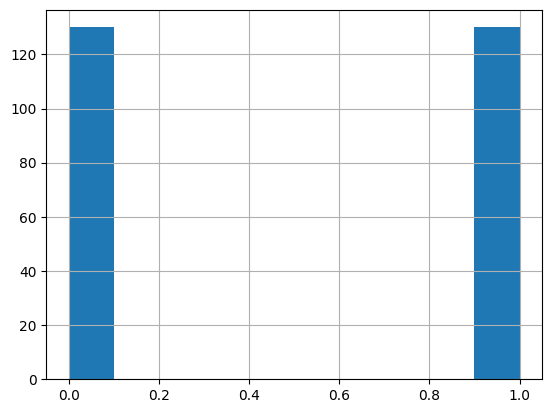

In [ ]:
import pandas as pd
ydf = pd.DataFrame(yy, columns = ['Column_A'])
ydf[ydf.columns[0]].hist()

The data set is balanced.

In [ ]:
print("max valuse for each channel:", np.max(XX, axis=(0, 1, 2)))
print("min valuse for each channel:", np.min(XX, axis=(0, 1, 2)))

max valuse for each channel: [224 208 229]
min valuse for each channel: [ 9  0 48]


So we have to `normalize` the input data to a range between 0 and 1(after generating augmentad images).
Normalization helps in improving the convergence and stability of the training process.

# split train and test:

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(XX, yy, test_size=0.2 )
print('number of test data:      ',len(X_test))
print('number of train data(before augmentation):',len(X_train))


number of test data:       52
number of train data(before augmentation): 208


#display a sample for each augmentation operator:

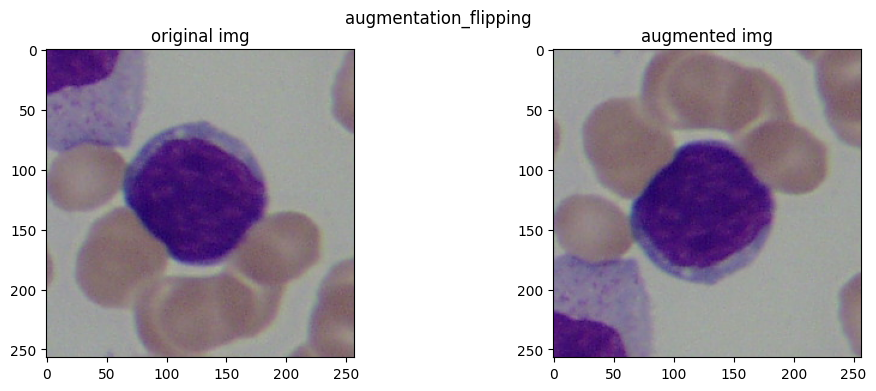

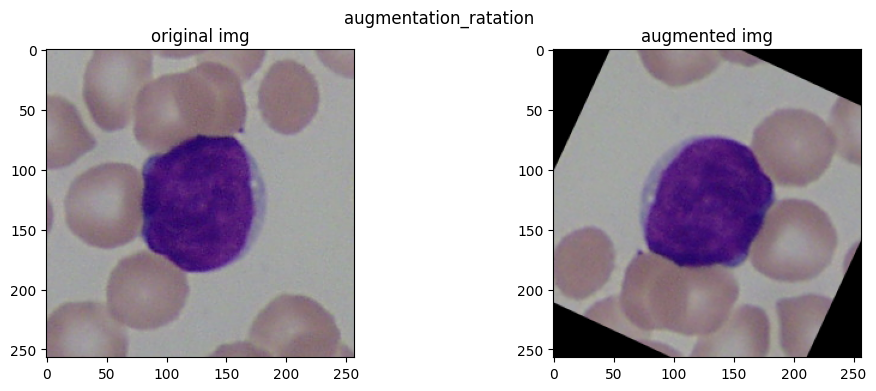

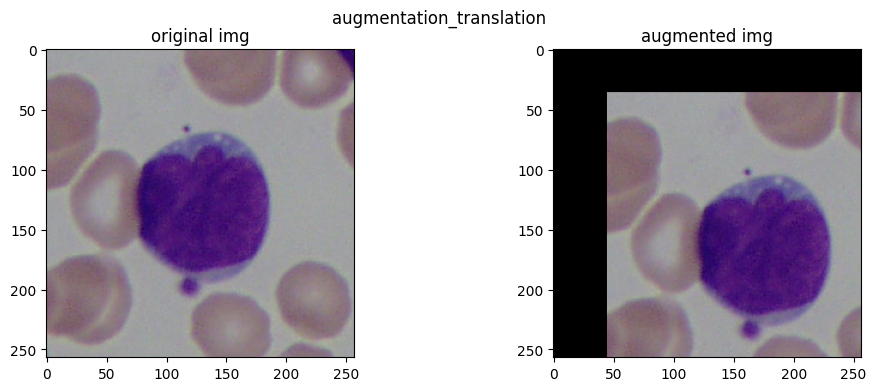

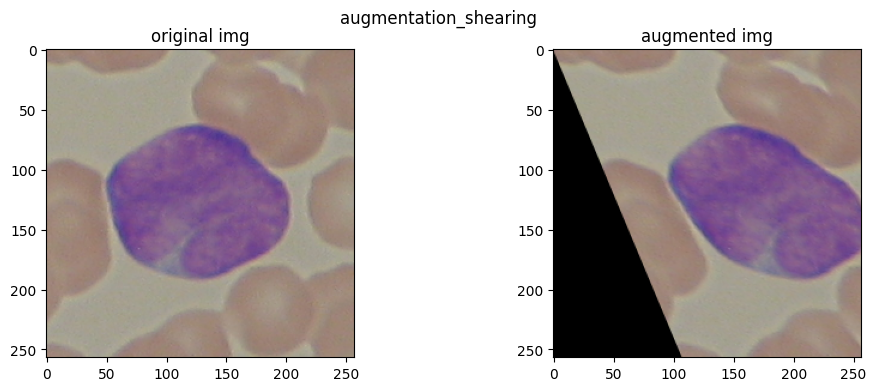

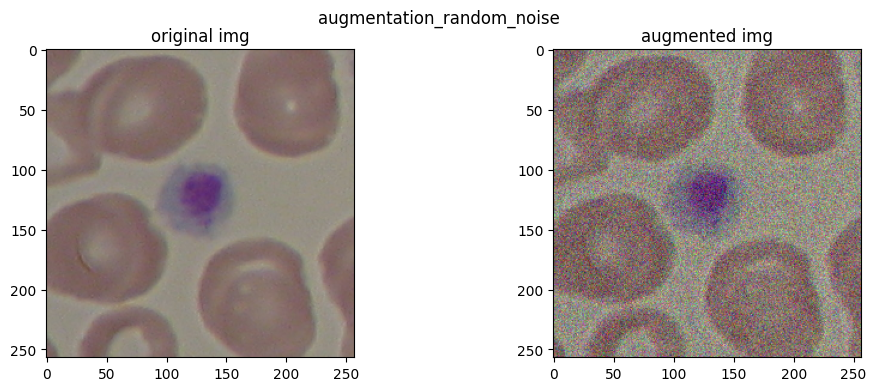

In [ ]:
for op in AUGMENTATION_OPERATORS:
  originalImg = random.choice(X_train)
  augmImg = op(originalImg)

  display_original_augmented_image(originalImg, augmImg, op.__name__)


#generate augmented images:
each original image is augmented by 3 random augment operator. Then halth of the generated images  augment again.

In [ ]:
imagesDirAugment = []
imagesClassAugment = []


for image, imageclass in zip(X_train, y_train):
  for _ in range(3):
    op = random.choice(AUGMENTATION_OPERATORS)
    augmImg = op(image)
    imagesDirAugment.append(augmImg)
    imagesClassAugment.append(imageclass)
for i in range(len(imagesDirAugment)//2):
  op = random.choice(AUGMENTATION_OPERATORS)
  augmImg = op(imagesDirAugment[i*2])
  imagesDirAugment.append(augmImg)
  imagesClassAugment.append(imagesClassAugment[i*2])


print('number of generated image:', len(imagesDirAugment))

number of generated image: 936


In [ ]:
X = np.empty((len(X_train)+len(imagesDirAugment), 257, 257, 3), dtype=np.uint8)
y = np.empty((len(y_train)+len(imagesDirAugment), 1), dtype=np.uint8)

for i, image in enumerate(X_train):
    X[i] = image
    y[i] = y_train[i]


for j, image in enumerate(imagesDirAugment):
    i+=1
    X[i] = image
    y[i] = imagesClassAugment[j]


print('number of training data:',len(X))

number of training data: 1144


###shuffle the original images and generated images

In [ ]:
# Get the permutation indices for shuffling
permutation = np.random.permutation(len(X))

X = X[permutation]
y = y[permutation]


###normalizing train and test set:

In [ ]:
X = X/255
X_test = X_test/255

In [ ]:
print("max valuse of test  for each channel:", np.max(X_test, axis=(0, 1, 2)))
print("min valuse of test  for each channel:", np.min(X_test, axis=(0, 1, 2)))
print("max valuse of train for each channel:", np.max(X, axis=(0, 1, 2)))
print("min valuse of train for each channel:", np.min(X, axis=(0, 1, 2)))

max valuse of test  for each channel: [0.80392157 0.78039216 0.75294118]
min valuse of test  for each channel: [0.03529412 0.         0.2       ]
max valuse of train for each channel: [0.87843137 0.81568627 0.89803922]
min valuse of train for each channel: [0. 0. 0.]


### Encode the target variable appropriately
(one-hot encoding with the to_categorical function )

In [ ]:
from keras.utils import to_categorical

y = to_categorical(y)
y_test = to_categorical(y_test)

# fit the model with given parameters:

In [ ]:
history = model.fit(X, y, batch_size=BATCHSIZE, epochs=NUMEPOCHS)

Epoch 1/500
12/12 [==============================] - 6s 148ms/step - loss: 0.6907 - accuracy: 0.5017
Epoch 2/500
12/12 [==============================] - 1s 87ms/step - loss: 0.6630 - accuracy: 0.6058
Epoch 3/500
12/12 [==============================] - 1s 95ms/step - loss: 0.5996 - accuracy: 0.7010
Epoch 4/500
12/12 [==============================] - 1s 123ms/step - loss: 0.5305 - accuracy: 0.7220
Epoch 5/500
12/12 [==============================] - 1s 122ms/step - loss: 0.4682 - accuracy: 0.7587
Epoch 6/500
12/12 [==============================] - 1s 82ms/step - loss: 0.4477 - accuracy: 0.7701
Epoch 7/500
12/12 [==============================] - 1s 82ms/step - loss: 0.4298 - accuracy: 0.7850
Epoch 8/500
12/12 [==============================] - 1s 81ms/step - loss: 0.4131 - accuracy: 0.7841
Epoch 9/500
12/12 [==============================] - 1s 83ms/step - loss: 0.4307 - accuracy: 0.7745
Epoch 10/500
12/12 [==============================] - 1s 84ms/step - loss: 0.4064 - accuracy: 0.7

##Evaluate the model on the test set

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)

2/2 [==============================] - 1s 194ms/step - loss: 0.0160 - accuracy: 0.9808


In [ ]:
def plot_accuracy_loss(history):
    fig = plt.figure(figsize=(20,10))

    # acc
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'-', label = "accuracy")
    plt.title("train_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # loss
    plt.subplot(222)
    plt.plot(history.history['loss'],'-', label = "loss")
    plt.title("train_loss ")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()


In [ ]:

from sklearn.metrics import confusion_matrix

def display_confusion_matrix(y_actual, y_pred):
  cm = confusion_matrix(y_actual, y_pred)

  # Plot confusion matrix
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  plt.title('Confusion Matrix')
  plt.colorbar()
  tick_marks = np.arange(2)
  plt.xticks(tick_marks, ['normal', 'abnormal'], rotation=45)
  plt.yticks(tick_marks, ['normal', 'abnormal'])

  # Fill the confusion matrix cells with values
  thresh = cm.max() / 2.0
  for i, j in np.ndindex(cm.shape):
      plt.text(j, i, format(cm[i, j], 'd'),
              horizontalalignment="center",
              color="white" if cm[i, j] > thresh else "black")

  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.tight_layout()
  plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from prettytable import PrettyTable

def get_performance(y_actual, y_pred ):
  acc = accuracy_score(y_actual, y_pred)

  cm = confusion_matrix(y_actual, y_pred)
  tn, fp, fn, tp = cm.ravel()

  precision = tp / (tp + fp)
  recall = tp / (tp + fn)

  specificity = tn / (tn + fp)
  return acc, precision, recall, specificity


In [ ]:
def show_performance(acc_test, precision_test, recall_test, specificity_test, acc_train, precision_train, recall_train, specificity_train ):

  table = PrettyTable()
  table.title = 'performance'

  table.field_names = ['','accuracy', 'precision', 'recall', 'specificity']

  table.add_row(['test', acc_test, precision_test, recall_test, specificity_test])
  table.add_row(['train' ,acc_train, precision_train, recall_train, specificity_train])

  print(table)


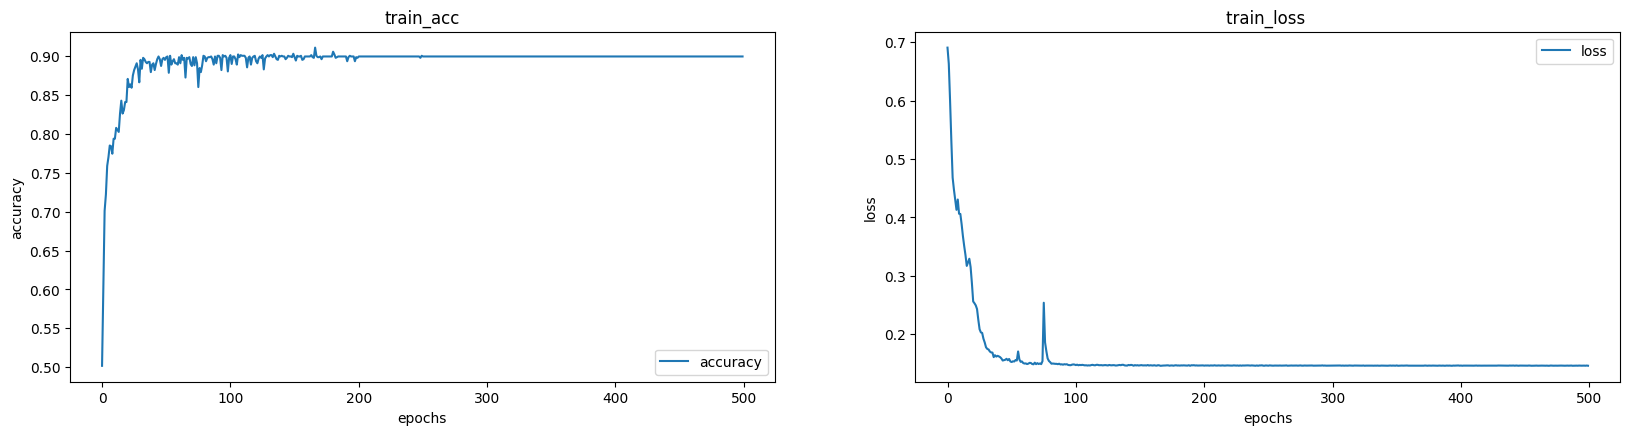

In [ ]:
plot_accuracy_loss(history)

In [ ]:

pred_test = model.predict(X_test)
y_pred_test = np.argmax(pred_test, axis=1)

pred_test = model.predict(X_test)
y_pred_test = np.argmax(pred_test, axis=1)

pred_train = model.predict(X)
y_pred_train = np.argmax(pred_train, axis=1)


36/36 [==============================] - 1s 24ms/step


#report the performance:

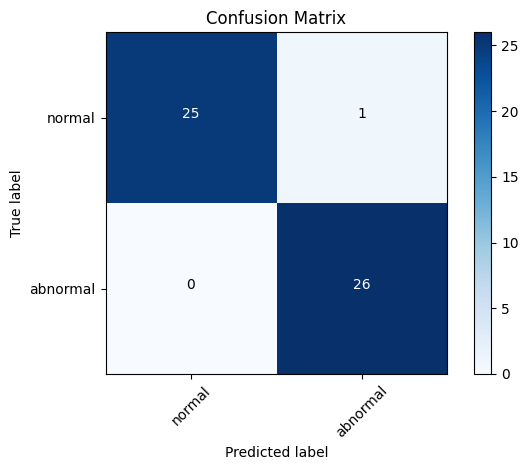

In [ ]:
display_confusion_matrix(y_test[:,1], y_pred_test)

In [ ]:
acc_test, precision_test, recall_test, specificity_test = get_performance(y_test[:,1], y_pred_test)
acc_train, precision_train, recall_train, specificity_train = get_performance(y[:,1], y_pred_train)

show_performance(acc_test, precision_test, recall_test, specificity_test, acc_train, precision_train, recall_train, specificity_train)

+-------+--------------------+--------------------+--------------------+--------------------+
|       |      accuracy      |     precision      |       recall       |    specificity     |
+-------+--------------------+--------------------+--------------------+--------------------+
|  test | 0.9807692307692307 | 0.9629629629629629 |        1.0         | 0.9615384615384616 |
| train | 0.8994755244755245 |        1.0         | 0.7978910369068541 |        1.0         |
+-------+--------------------+--------------------+--------------------+--------------------+




---



---



#**Conclusion**

**augmentations**:
flipping, histogram equalization, ratation, translation, shearing, random noise

test size:       52 \
original train:  208 \
generated trian: 936 \
whole train:     1144 \




---


---


---
---
---

# **try other models**



#**$InceptionV3$**

In [ ]:
from tensorflow.keras.applications import InceptionV3
from keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Flatten


# Load the InceptionV3 model without the top classification layer
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(257, 257,3))

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Add a new top classification layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)

# Create the final model
insModel = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
insModel.compile(optimizer=Adam(), loss=LOSS, metrics=['accuracy'])

# Print the model summary
insModel.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 257, 257, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_188 (Conv2D)            (None, 128, 128, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_188 (Batch  (None, 128, 128, 32  96         ['conv2d_188[0][0]']             
 Normalization)                 )                                                           

In [ ]:
history3 = insModel.fit(X, y, batch_size=BATCHSIZE, epochs=200)

Epoch 1/200
12/12 [==============================] - 22s 472ms/step - loss: 0.6555 - accuracy: 0.6617
Epoch 2/200
12/12 [==============================] - 3s 251ms/step - loss: 0.4782 - accuracy: 0.7369
Epoch 3/200
12/12 [==============================] - 3s 266ms/step - loss: 0.3838 - accuracy: 0.8007
Epoch 4/200
12/12 [==============================] - 4s 309ms/step - loss: 0.3351 - accuracy: 0.8182
Epoch 5/200
12/12 [==============================] - 3s 288ms/step - loss: 0.3110 - accuracy: 0.8330
Epoch 6/200
12/12 [==============================] - 3s 253ms/step - loss: 0.2933 - accuracy: 0.8435
Epoch 7/200
12/12 [==============================] - 3s 255ms/step - loss: 0.2972 - accuracy: 0.8339
Epoch 8/200
12/12 [==============================] - 3s 281ms/step - loss: 0.2655 - accuracy: 0.8505
Epoch 9/200
12/12 [==============================] - 3s 260ms/step - loss: 0.2510 - accuracy: 0.8540
Epoch 10/200
12/12 [==============================] - 3s 258ms/step - loss: 0.2426 - accur

In [ ]:
loss, accuracy = insModel.evaluate(X_test, y_test)

2/2 [==============================] - 9s 2s/step - loss: 0.3298 - accuracy: 0.9038


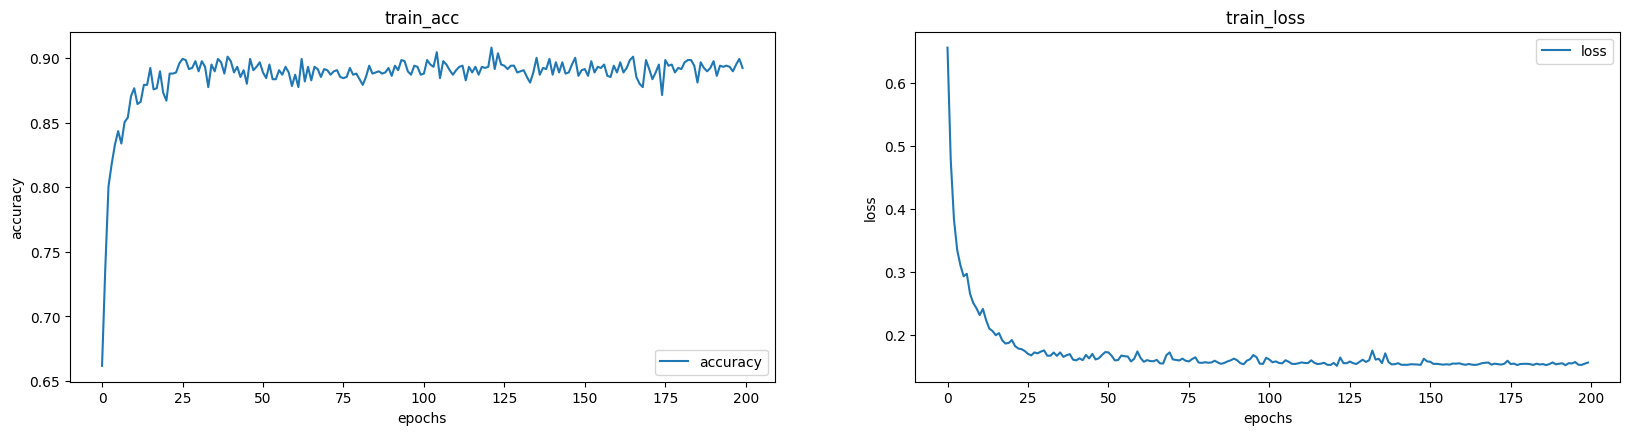

In [ ]:
plot_accuracy_loss(history3)

36/36 [==============================] - 7s 207ms/step


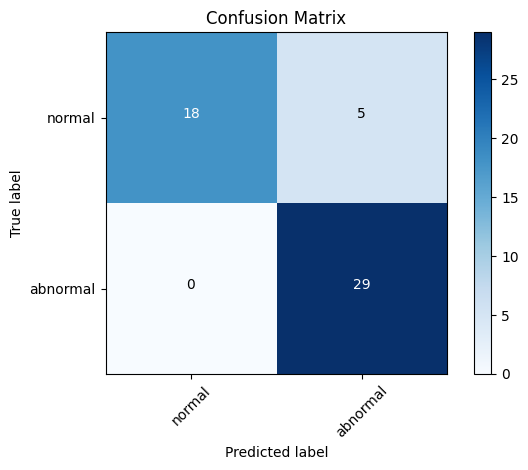

In [ ]:

pred_test = insModel.predict(X_test)
y_pred_test = np.argmax(pred_test, axis=1)

pred_test = insModel.predict(X_test)
y_pred_test = np.argmax(pred_test, axis=1)

pred_train = insModel.predict(X)
y_pred_train = np.argmax(pred_train, axis=1)


display_confusion_matrix(y_test[:,1], y_pred_test)

In [ ]:
acc_test, precision_test, recall_test, specificity_test = get_performance(y_test[:,1], y_pred_test)
acc_train, precision_train, recall_train, specificity_train = get_performance(y[:,1], y_pred_train)

show_performance(acc_test, precision_test, recall_test, specificity_test, acc_train, precision_train, recall_train, specificity_train)

+-------+--------------------+--------------------+--------+--------------------+
|       |      accuracy      |     precision      | recall |    specificity     |
+-------+--------------------+--------------------+--------+--------------------+
|  test | 0.9038461538461539 | 0.8529411764705882 |  1.0   | 0.782608695652174  |
| train | 0.8924825174825175 | 0.8201754385964912 |  1.0   | 0.7890222984562607 |
+-------+--------------------+--------------------+--------+--------------------+


---
----
#Compare CNN with Inception:


In [ ]:
#CNN performance:

# +-------+--------------------+--------------------+--------------------+--------------------+
# |       |      accuracy      |     precision      |       recall       |    specificity     |
# +-------+--------------------+--------------------+--------------------+--------------------+
# |  test | 0.9807692307692307 | 0.9629629629629629 |        1.0         | 0.9615384615384616 |
# | train | 0.8994755244755245 |        1.0         | 0.7978910369068541 |        1.0         |
# +-------+--------------------+--------------------+--------------------+--------------------+


**CNN** is better than **Inception** for every parameters except **specificity**.